# Project 

In [451]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Data Description...**

In [452]:
food_inspections = pd.read_csv('data/food-inspections.csv', sep=',')

**Drop the columns we don't need**

We don't need the location since we already have the latitude and longitude columns. 
The Zip codes are not required either.

In [453]:
food_inspections = food_inspections.drop(['Location', 'Zip', 'Zip Codes','Historical Wards 2003-2015', 'Community Areas', 'Census Tracts','Wards'], axis=1)

In [454]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,CHICAGO,IL,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,CHICAGO,IL,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884.0,Restaurant,Risk 1 (High),3028 W ARMITAGE AVE,CHICAGO,IL,2019-10-24T00:00:00.000,Canvass,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.917539,-87.703728
3,2320430,LAO PENG YOU LLC,LAO PENG YOU,2694477.0,Restaurant,Risk 1 (High),2020 W CHICAGO,CHICAGO,IL,2019-10-24T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.896005,-87.677938
4,2320384,ARBOR,ARBOR,2363029.0,Restaurant,Risk 1 (High),2545 W DIVERSEY AVE,CHICAGO,IL,2019-10-24T00:00:00.000,Recent Inspection,Pass w/ Conditions,14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...,41.932025,-87.692169


In [455]:
food_inspections['DBA Name'].isnull().values.any()

False

**Check the cities**

We see that chicago is there several times. 

In [456]:
food_inspections.groupby('City')['DBA Name'].count().sort_values(ascending=False)

City
CHICAGO               194066
Chicago                  319
chicago                   97
CCHICAGO                  46
SCHAUMBURG                24
                       ...  
COUNTRY CLUB HILLS         1
DES PLAINES                1
GRIFFITH                   1
alsip                      1
GLENCOE                    1
Name: DBA Name, Length: 71, dtype: int64

In [457]:
def city_clear(city):
    city = str(city).lower()
    if city == 'cchicago':
        city = 'chicago'
    return city  

food_inspections.City = food_inspections.City.apply(city_clear)

In [458]:
food_inspections.groupby('City')['DBA Name'].count().sort_values(ascending=False)

City
chicago               194540
nan                      139
schaumburg                24
maywood                   16
elk grove village         13
                       ...  
country club hills         1
des plaines                1
griffith                   1
wilmette                   1
glencoe                    1
Name: DBA Name, Length: 66, dtype: int64

**Deleting other cities than Chicago**

We keep only chicago. Most data is overthere and the rest is not required. We check the state as well (different Chicago ?). At the end, we are sure to work only with restaurants in Chicago, Illinois.

In [459]:
food_inspections = food_inspections[food_inspections.City == 'chicago']

In [460]:
food_inspections.groupby('City')['DBA Name'].count().sort_values(ascending=False)

City
chicago    194540
Name: DBA Name, dtype: int64

In [461]:
food_inspections.groupby('State')['DBA Name'].count().sort_values(ascending=False)

State
IL    194517
Name: DBA Name, dtype: int64

In [462]:
food_inspections = food_inspections.drop(['City','State'], axis=1)

In [463]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884.0,Restaurant,Risk 1 (High),3028 W ARMITAGE AVE,2019-10-24T00:00:00.000,Canvass,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.917539,-87.703728
3,2320430,LAO PENG YOU LLC,LAO PENG YOU,2694477.0,Restaurant,Risk 1 (High),2020 W CHICAGO,2019-10-24T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.896005,-87.677938
4,2320384,ARBOR,ARBOR,2363029.0,Restaurant,Risk 1 (High),2545 W DIVERSEY AVE,2019-10-24T00:00:00.000,Recent Inspection,Pass w/ Conditions,14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...,41.932025,-87.692169


**Checking the license numbers of restaurants**

We check if don't have duplicates. Some places were inspected several times and have thus multiple rows in the dataset. We want to count the number of inspections done on each establishment so we will transform the data set to make 'Establishment'-centric.

In [464]:
license_count = food_inspections.groupby("License #").count().sort_values(by='DBA Name', ascending=False)

In [465]:
license_count['Inspection ID'].head()

License #
0.0          505
1354323.0    192
14616.0      175
1574001.0     83
1974745.0     59
Name: Inspection ID, dtype: int64

In [466]:
food_inspections.groupby("License #")['Inspection Date'].count().sort_values(ascending=False)

License #
0.0          505
1354323.0    192
14616.0      175
1574001.0     83
1974745.0     59
            ... 
1445749.0      1
1445739.0      1
1445730.0      1
1445710.0      1
9999999.0      1
Name: Inspection Date, Length: 37086, dtype: int64

**New Year format ?**

In [467]:
food_inspections['year'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[0])
food_inspections['month'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[1])
food_inspections['date'] = food_inspections['month'] + '/' + food_inspections['year']
food_inspections = food_inspections.drop(['Inspection Date','year','month'], axis=1)

In [468]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Type,Results,Violations,Latitude,Longitude,date
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,10/2019
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,10/2019
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884.0,Restaurant,Risk 1 (High),3028 W ARMITAGE AVE,Canvass,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.917539,-87.703728,10/2019
3,2320430,LAO PENG YOU LLC,LAO PENG YOU,2694477.0,Restaurant,Risk 1 (High),2020 W CHICAGO,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.896005,-87.677938,10/2019
4,2320384,ARBOR,ARBOR,2363029.0,Restaurant,Risk 1 (High),2545 W DIVERSEY AVE,Recent Inspection,Pass w/ Conditions,14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAG...,41.932025,-87.692169,10/2019


In [469]:
food_inspections['test'] = food_inspections['Inspection ID'].astype(str) + food_inspections['License #'].astype(str) + food_inspections['date'].astype(str)
food_inspections.test.is_unique

False

In [470]:
print('Number of rows in dataset before deleting the duplicates: {}'.format(food_inspections.shape))
food_inspections = food_inspections.drop_duplicates(subset=['test'], keep=False)
print('Number of rows in dataset after deleting the duplicates: {}'.format(food_inspections.shape))

Number of rows in dataset before deleting the duplicates: (194540, 14)
Number of rows in dataset after deleting the duplicates: (194340, 14)


In [480]:
food_inspections = food_inspections.drop(['test'], axis=1)

**Creating working dataset**



In [481]:
food_inspections_resto = food_inspections

In [482]:
count = food_inspections_resto.groupby('License #')['Inspection ID'].count()
food_inspections_resto = pd.merge(food_inspections_resto, count, left_on='License #',right_on='License #')
food_inspections_resto = food_inspections_resto.rename(columns={'Inspection ID_y':'# of Inspections','Inspection ID_x':'Inspection ID'})

In [483]:
food_inspections_resto = food_inspections_resto.drop(['date','Inspection ID','DBA Name','AKA Name','Violations','Results','Inspection Type'], axis=1)

In [484]:
food_inspections_resto.head()

,License #,Facility Type,Risk,Address,Latitude,Longitude,# of Inspections
0,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23
1,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23
2,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23
3,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23
4,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23


In [485]:
print('Number of rows to be deleted: {}'.format(food_inspections_resto[food_inspections_resto.duplicated()].shape))
food_inspections_resto = food_inspections_resto.drop_duplicates()
print('Number of rows in dataset after deletion: {}'.format(food_inspections_resto.shape))

(156511, 7)

In [489]:
food_inspections_resto.head()

,License #,Facility Type,Risk,Address,Latitude,Longitude,# of Inspections
0,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,41.965719,-87.708538,23
23,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,41.968820,-87.682292,2
25,2092884.0,Restaurant,Risk 1 (High),3028 W ARMITAGE AVE,41.917539,-87.703728,12
37,2694477.0,Restaurant,Risk 1 (High),2020 W CHICAGO,41.896005,-87.677938,3
40,2363029.0,Restaurant,Risk 1 (High),2545 W DIVERSEY AVE,41.932025,-87.692169,6


**Plot Geographical loc of restaurants**

In [495]:
import os
import pandas as pd
import json

import folium

In [496]:
folium.__version__ == '0.10.0'

True

In [499]:
chicago_coord = [41.85, -87.7]

In [540]:
m = folium.Map(location=chicago_coord)
m

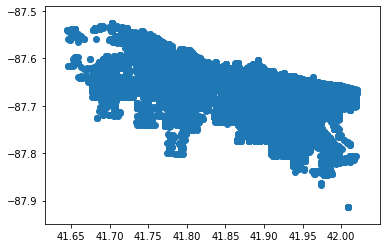

In [494]:
latitudes = food_inspections_resto.Latitude
longitudes = food_inspections_resto.Longitude

plt.figure()
plt.scatter(latitudes,longitudes)

In [530]:
# Need more data cleaning
food_inspections_resto = food_inspections_resto.dropna()

In [554]:
for index, row in food_inspections_resto.iterrows():
    if index < 1000:
        folium.Marker([row["Latitude"], row["Longitude"]], popup=str(index)).add_to(m)
    else: 
        break

In [555]:
m